<a href="https://colab.research.google.com/github/muhmmadzs/Autoencoder/blob/main/Class_Exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**This notebook contain the example of application of  autoencoder for bridge damage detection. **

For question and queries Contact:muhammad.z.sarwar@ntnu.no


> For runing on **COLAB** run the following cell.







In [1]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


This cell contain the script to import all the required libraries and function 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import scipy.io
from tensorflow.keras.optimizers import RMSprop, Adam
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from tensorflow.keras.models import load_model
import time
import time
from random import shuffle
import joblib  # save scaler
from tensorflow.keras.layers import Activation, Dropout, Dense,Conv1DTranspose,Concatenate,Input,Conv1D,MaxPooling1D,Flatten,UpSampling1D,Reshape
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from tensorflow.keras.models import load_model,Model
from tensorflow.keras.utils import plot_model
from scipy import signal
from tensorflow.keras import backend as K

Make sure that your notebook is able access available GPU.
If not follow these steps
* Go to the tab and select Runtime
* In Runtime select "Change Runtime type"
* In Dialogue box Change "Hardware accelerator" to GPU


In [3]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

#Loading dataset for training. 
The training dataset contain the accleration response from Single degree of freedom system (Vehicle) traversing the bridge as shown in Figure Ref [[1]](https://www.sciencedirect.com/science/article/pii/S0022460X04005863). For each crossing event variation in vehicle speed and mass is introduced.
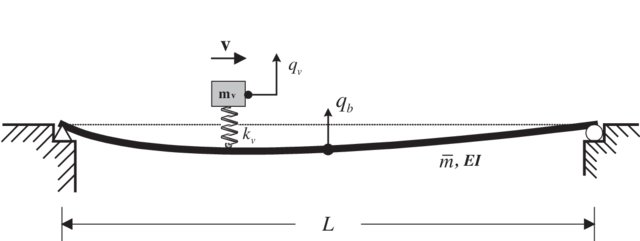

Download Dataset folder by clicking here [link](
https://drive.google.com/drive/folders/1M4gXVAAOhidvDCI1xnWdVGNDQJ93Sv3M?usp=sharing).
Data-Set inlcudes:

* 1000 Vehicle crossing for healthy Bridge (Used for training)
* 1000 Vehicle crossing for healthy Bridge.       :DC0
* 1000 Vehicle crossing for 15% damage at midspan :DC1
* 1000 Vehicle crossing for 30% damage at midspan :DC2




In [4]:
#Loading Training Data_Set
mat = scipy.io.loadmat('/content/gdrive/MyDrive/ML Class/Data_Healthy.mat')
X_data = mat['input_train']
print(np.shape(X_data))

(1000, 1500)



# Normalised the data set with zero mean and unit varaince 

In [5]:
# Standarization of Training Data Set 
X_data = np.reshape(X_data, [X_data.shape[0], X_data.shape[1], 1])
X_data_flatten = np.reshape(X_data, [X_data.shape[0]*X_data.shape[1], X_data.shape[2]])
scaler_X = StandardScaler()
scaler_X.fit(X_data_flatten)
X_data_flatten_map = scaler_X.transform(X_data_flatten)
X_data_map = np.reshape(X_data_flatten_map, [X_data.shape[0], X_data.shape[1], X_data.shape[2]])
print(np.shape(X_data_map))


(1000, 1500, 1)


# Split the data into training and validation 

In [6]:
# Dividing Data_Set into Training and Validation

N=700;
# Input for Conv_AE model
X_train = X_data_map[0:N]
X_vali  = X_data_map[N:]
print(np.shape(X_train))
print(np.shape(X_vali))

# input for basic AE model
X_train_dense=X_train[:,:,-1]
X_vali_dense=X_vali[:,:,-1]

print(np.shape(X_train_dense))


(700, 1500, 1)
(300, 1500, 1)
(700, 1500)


In [7]:
data_dim = X_train.shape[2]
timesteps = X_train.shape[1]
print(data_dim, timesteps)

1 1500


#Architecture of Simple Autoencoder model


In [8]:
# Build Autoencoder model using basic layers.
input_sig = Input(shape=(timesteps,))
encoded = Dense(128, activation='relu')(input_sig)
encoded = Dense(64, activation='relu')(encoded)
encoded = Dense(32, activation='relu')(encoded)

encoded = Dense(16, activation='relu')(encoded)

decoded = Dense(32, activation='relu')(encoded)
decoded = Dense(64, activation='relu')(encoded)
decoded = Dense(128, activation='relu')(decoded)
decoded = Dense(timesteps, activation='linear')(decoded)

AE = Model(input_sig, decoded) 
encoder=Model(input_sig,encoded)

AE.summary()




Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1500)]            0         
                                                                 
 dense (Dense)               (None, 128)               192128    
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 16)                528       
                                                                 
 dense_5 (Dense)             (None, 64)                1088      
                                                                 
 dense_6 (Dense)             (None, 128)               8320  

Compile and train the AE model

In [9]:
# Compile the Model and Start Training 
adam = Adam(lr=0.001, decay=0.0001)
AE.compile(loss='mean_squared_error',    # categorical_crossentropy, mean_squared_error, mean_absolute_error
              optimizer=adam,               
              metrics=['mse'])
epochs=500
batch_size=64
AE.fit(X_train_dense, X_train_dense,
          batch_size=batch_size,
          validation_data=(X_vali_dense, X_vali_dense),
          shuffle=True,
          epochs=epochs
          )

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/500
11/11 [==============================] - 3s 25ms/step - loss: 0.8208 - mse: 0.8208 - val_loss: 0.5250 - val_mse: 0.5250
Epoch 2/500
11/11 [==============================] - 0s 6ms/step - loss: 0.3744 - mse: 0.3744 - val_loss: 0.1925 - val_mse: 0.1925
Epoch 3/500
11/11 [==============================] - 0s 6ms/step - loss: 0.1413 - mse: 0.1413 - val_loss: 0.0665 - val_mse: 0.0665
Epoch 4/500
11/11 [==============================] - 0s 6ms/step - loss: 0.0574 - mse: 0.0574 - val_loss: 0.0367 - val_mse: 0.0367
Epoch 5/500
11/11 [==============================] - 0s 6ms/step - loss: 0.0314 - mse: 0.0314 - val_loss: 0.0232 - val_mse: 0.0232
Epoch 6/500
11/11 [==============================] - 0s 6ms/step - loss: 0.0185 - mse: 0.0185 - val_loss: 0.0151 - val_mse: 0.0151
Epoch 7/500
11/11 [==============================] - 0s 6ms/step - loss: 0.0116 - mse: 0.0116 - val_loss: 0.0102 - val_mse: 0.0102
Epoch 8/500
11/11 [==============================] - 0s 6ms/step - loss: 0.0077 - 

Plotting for AE autonencoder

5/5 [==============================] - 0s 3ms/step


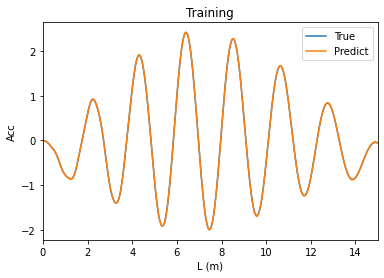

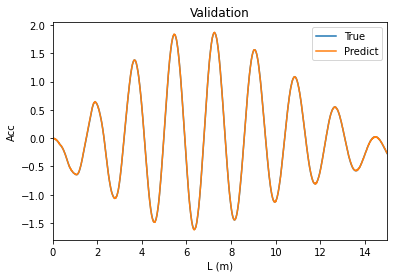

In [10]:
# plotting Training and testing data 
X_train_Pred_dense=AE.predict(X_train_dense,batch_size=batch_size)
X_vali_Pred_dense=AE.predict(X_vali_dense,batch_size=batch_size)
dist=np.linspace(0, 15, num=1500)
for sample in range(1):
    plt.figure()
    plt.plot(dist,X_train_dense[sample,:], label='True')
    plt.plot(dist,X_train_Pred_dense[sample,:], label='Predict')
    plt.xlim(0,15)
    plt.xlabel('L (m)')
    plt.ylabel('Acc')
    plt.title('Training')
    plt.legend()

for sample in range(1):
    plt.figure()
    plt.plot(dist,X_vali_dense[sample,:], label='True')
    plt.plot(dist,X_vali_Pred_dense[sample,:], label='Predict')
    plt.xlim(0,15)
    plt.xlabel('L (m)')
    plt.ylabel('Acc')
    plt.title('Validation')
    plt.legend()

Testing on New datasets

In [11]:
# Loading Data for Damage Evaluation and Testing & Setting the scale.
mat00 = scipy.io.loadmat('/content/gdrive/MyDrive/ML Class/Data_Damage00.mat')
X_Dam_00 = mat00['input_test']
mat15 = scipy.io.loadmat('/content/gdrive/MyDrive/ML Class/Data_Damage15.mat')
X_Dam_15 = mat15['input_test']
mat30 = scipy.io.loadmat('/content/gdrive/MyDrive/ML Class/Data_Damage30.mat')
X_Dam_30 = mat30['input_test']

# Scaling for DC0
X_Dam_00 = np.reshape(X_Dam_00, [X_Dam_00.shape[0], X_Dam_00.shape[1], 1])
X_Dam_00_flatten = np.reshape(X_Dam_00, [X_Dam_00.shape[0]*X_Dam_00.shape[1], X_Dam_00.shape[2]])
X_Dam_00_flatten_map = scaler_X.transform(X_Dam_00_flatten)
X_Dam_00_map = np.reshape(X_Dam_00_flatten_map, [X_Dam_00.shape[0], X_Dam_00.shape[1], X_Dam_00.shape[2]])
X_Dam_00_dense=X_Dam_00[:,:,-1]
X_Dam_00_map_dense=X_Dam_00_map[:,:,-1]

# Scaling for DC1

X_Dam_15 = np.reshape(X_Dam_15, [X_Dam_15.shape[0], X_Dam_15.shape[1], 1])
X_Dam_15_flatten = np.reshape(X_Dam_15, [X_Dam_15.shape[0]*X_Dam_15.shape[1], X_Dam_15.shape[2]])
X_Dam_15_flatten_map = scaler_X.transform(X_Dam_15_flatten)
X_Dam_15_map = np.reshape(X_Dam_15_flatten_map, [X_Dam_15.shape[0], X_Dam_15.shape[1], X_Dam_15.shape[2]])
X_Dam_15_dense=X_Dam_15[:,:,-1]
X_Dam_15_map_dense=X_Dam_15_map[:,:,-1]
# Scaling for DC2
X_Dam_30 = np.reshape(X_Dam_30, [X_Dam_30.shape[0], X_Dam_30.shape[1], 1])
X_Dam_30_flatten = np.reshape(X_Dam_30, [X_Dam_30.shape[0]*X_Dam_30.shape[1], X_Dam_30.shape[2]])
X_Dam_30_flatten_map = scaler_X.transform(X_Dam_30_flatten)
X_Dam_30_map = np.reshape(X_Dam_30_flatten_map, [X_Dam_30.shape[0], X_Dam_30.shape[1], X_Dam_30.shape[2]])
X_Dam_30_dense=X_Dam_30[:,:,-1]
X_Dam_30_map_dense=X_Dam_30_map[:,:,-1]

16/16 [==============================] - 0s 2ms/step


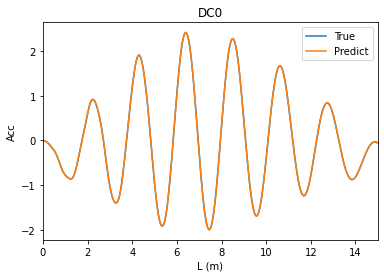

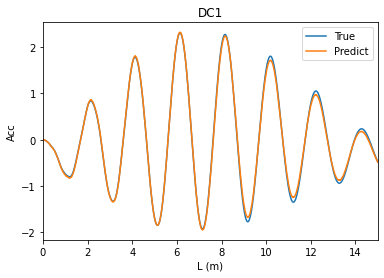

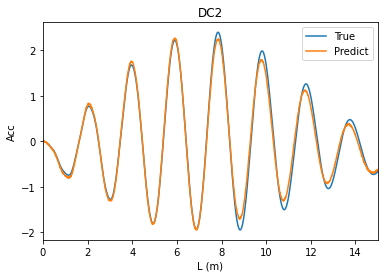

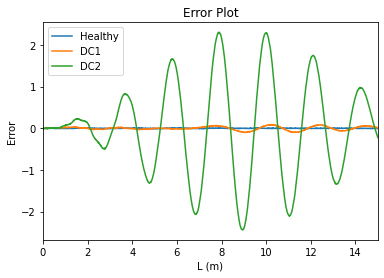

In [12]:
# plotting Training and testing data 
X_Dam_00_Pred_dense=AE.predict(X_Dam_00_map_dense,batch_size=batch_size)
X_Dam_15_Pred_dense=AE.predict(X_Dam_15_map_dense,batch_size=batch_size)
X_Dam_30_Pred_dense=AE.predict(X_Dam_30_map_dense,batch_size=batch_size)



for sample in range(1):
    plt.figure()
    plt.plot(dist,X_Dam_00_map_dense[sample,:], label='True')
    plt.plot(dist,X_Dam_00_Pred_dense[sample,:], label='Predict')
    plt.xlim(0,15)
    plt.xlabel('L (m)')
    plt.ylabel('Acc')
    plt.title('DC0')
    plt.legend()



for sample in range(1):
    plt.figure()
    plt.plot(dist,X_Dam_15_map_dense[sample,:], label='True')
    plt.plot(dist,X_Dam_15_Pred_dense[sample,:], label='Predict')
    plt.xlim(0,15)
    plt.xlabel('L (m)')
    plt.ylabel('Acc')
    plt.title('DC1')
    plt.legend()



for sample in range(1):
    plt.figure()
    plt.plot(dist,X_Dam_30_map_dense[sample,:], label='True')
    plt.plot(dist,X_Dam_30_Pred_dense[sample,:], label='Predict')
    plt.xlim(0,15)
    plt.xlabel('L (m)')
    plt.ylabel('Acc')
    plt.title('DC2')
    plt.legend()

plt.figure()
plt.plot(dist,X_Dam_00_map_dense[2,:]-X_Dam_00_Pred_dense[2,:],label='Healthy')
plt.plot(dist,X_Dam_15_map_dense[2,:]-X_Dam_15_Pred_dense[2,:],label='DC1')
plt.plot(dist,X_Dam_15_map_dense[2,:]-X_Dam_30_Pred_dense[2,:],label='DC2')
plt.xlim(0,15)
plt.xlabel('L (m)')
plt.ylabel('Error')
plt.title('Error Plot')
plt.legend()

#Architecture of Convolutional Autoencoder model


In [13]:
# Build Convlutional Autoencoder model.
input_sig = Input(shape=(timesteps,data_dim)) 


Encoder = Conv1D(512,3,activation='relu', padding='same')(input_sig)    
Encoder = MaxPooling1D(3)(Encoder) 

Encoder = Conv1D(256,3,activation='relu', padding='same')(Encoder)   
Encoder = MaxPooling1D(2)(Encoder) 

Encoder = Conv1D(64,3, activation='relu', padding='same')(Encoder)    
Encoder = MaxPooling1D(2)(Encoder) 

Encoder = Conv1D(32,3, activation='relu', padding='same')(Encoder)   




flat = Flatten()(Encoder) 
encoded = Dense(4000,activation = 'relu')(flat) 

encoded = Dense(16,activation = 'linear',kernel_regularizer=tf.keras.regularizers.l1(1e-4))(encoded) 

Decoder =  Dense(4000,activation = 'relu')(encoded) 
Decoder =  Reshape((125,32))(Decoder)

Decoder = Conv1D(32, 3,activation='relu', padding='same')(Decoder) 

Decoder = UpSampling1D(2)(Decoder) 
Decoder = Conv1D(64, 3,activation='relu', padding='same')(Decoder) 


Decoder = UpSampling1D(2)(Decoder) 
Decoder = Conv1D(256, 3,activation='relu', padding='same')(Decoder) 

Decoder = UpSampling1D(3)(Decoder) 
Decoder = Conv1D(512, 3,activation='relu', padding='same')(Decoder) 



decoded = Conv1D(data_dim,1, padding='same', activation = 'linear')(Decoder) 


Conv_AE = Model(input_sig, decoded) 
encoder=Model(input_sig,encoded)

Conv_AE.summary()





Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1500, 1)]         0         
                                                                 
 conv1d (Conv1D)             (None, 1500, 512)         2048      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 500, 512)         0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 500, 256)          393472    
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 250, 256)         0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 250, 64)           4921

In [14]:
# Compile the Model and Start Training 
adam = Adam(lr=0.001, decay=0.0001)
Conv_AE.compile(loss='mean_squared_error',    # categorical_crossentropy, mean_squared_error, mean_absolute_error
              optimizer=adam,               
              metrics=['mse'])
epochs=1000
batch_size=64
Conv_AE.fit(X_train, X_train,
          batch_size=batch_size,
          validation_data=(X_vali, X_vali),
          shuffle=True,
          epochs=epochs
          )

Epoch 1/1000


/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


11/11 [==============================] - 15s 365ms/step - loss: 0.9526 - mse: 0.8539 - val_loss: 0.4973 - val_mse: 0.4204
Epoch 2/1000
11/11 [==============================] - 2s 162ms/step - loss: 0.2595 - mse: 0.1936 - val_loss: 0.1074 - val_mse: 0.0527
Epoch 3/1000
11/11 [==============================] - 2s 162ms/step - loss: 0.0862 - mse: 0.0381 - val_loss: 0.0638 - val_mse: 0.0219
Epoch 4/1000
11/11 [==============================] - 2s 162ms/step - loss: 0.0551 - mse: 0.0155 - val_loss: 0.0479 - val_mse: 0.0107
Epoch 5/1000
11/11 [==============================] - 2s 162ms/step - loss: 0.0432 - mse: 0.0081 - val_loss: 0.0393 - val_mse: 0.0063
Epoch 6/1000
11/11 [==============================] - 2s 163ms/step - loss: 0.0364 - mse: 0.0049 - val_loss: 0.0335 - val_mse: 0.0037
Epoch 7/1000
11/11 [==============================] - 2s 163ms/step - loss: 0.0317 - mse: 0.0031 - val_loss: 0.0294 - val_mse: 0.0022
Epoch 8/1000
11/11 [==============================] - 2s 164ms/step - loss

 Plotting 

5/5 [==============================] - 0s 50ms/step


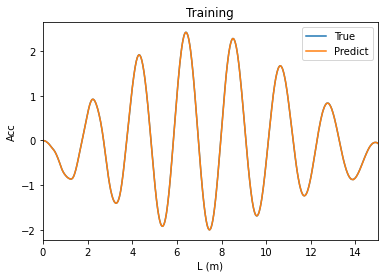

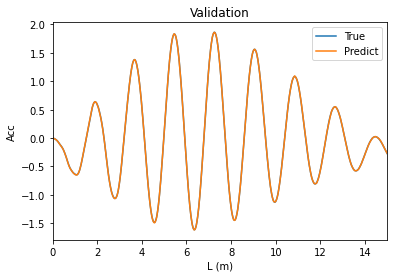

In [15]:
# plotting Training and testing data 
X_train_Pred=Conv_AE.predict(X_train,batch_size=batch_size)
X_vali_Pred=Conv_AE.predict(X_vali,batch_size=batch_size)
dist=np.linspace(0, 15, num=1500)
for sample in range(1):
    plt.figure()
    plt.plot(dist,X_train[sample,:], label='True')
    plt.plot(dist,X_train_Pred[sample][:, 0], label='Predict')
    plt.xlim(0,15)
    plt.xlabel('L (m)')
    plt.ylabel('Acc')
    plt.title('Training')
    plt.legend()

for sample in range(1):
    plt.figure()
    plt.plot(dist,X_vali[sample,:], label='True')
    plt.plot(dist,X_vali_Pred[sample][:, 0], label='Predict')
    plt.xlim(0,15)
    plt.xlabel('L (m)')
    plt.ylabel('Acc')
    plt.title('Validation')
    plt.legend()


Testing on New dataset

In [16]:
# Loading Data for Damage Evaluation and Testing & Setting the scale.
mat00 = scipy.io.loadmat('/content/gdrive/MyDrive/ML Class/Data_Damage00.mat')
X_Dam_00 = mat00['input_test']
mat15 = scipy.io.loadmat('/content/gdrive/MyDrive/ML Class/Data_Damage15.mat')
X_Dam_15 = mat15['input_test']
mat30 = scipy.io.loadmat('/content/gdrive/MyDrive/ML Class/Data_Damage30.mat')
X_Dam_30 = mat30['input_test']

# Scaling for DC0
X_Dam_00 = np.reshape(X_Dam_00, [X_Dam_00.shape[0], X_Dam_00.shape[1], 1])
X_Dam_00_flatten = np.reshape(X_Dam_00, [X_Dam_00.shape[0]*X_Dam_00.shape[1], X_Dam_00.shape[2]])
X_Dam_00_flatten_map = scaler_X.transform(X_Dam_00_flatten)
X_Dam_00_map = np.reshape(X_Dam_00_flatten_map, [X_Dam_00.shape[0], X_Dam_00.shape[1], X_Dam_00.shape[2]])
X_Dam_00_Dense=X_Dam_00[:,:,-1]
# Scaling for DC1

X_Dam_15 = np.reshape(X_Dam_15, [X_Dam_15.shape[0], X_Dam_15.shape[1], 1])
X_Dam_15_flatten = np.reshape(X_Dam_15, [X_Dam_15.shape[0]*X_Dam_15.shape[1], X_Dam_15.shape[2]])
X_Dam_15_flatten_map = scaler_X.transform(X_Dam_15_flatten)
X_Dam_15_map = np.reshape(X_Dam_15_flatten_map, [X_Dam_15.shape[0], X_Dam_15.shape[1], X_Dam_15.shape[2]])
X_Dam_15_Dense=X_Dam_15[:,:,-1]

# Scaling for DC2
X_Dam_30 = np.reshape(X_Dam_30, [X_Dam_30.shape[0], X_Dam_30.shape[1], 1])
X_Dam_30_flatten = np.reshape(X_Dam_30, [X_Dam_30.shape[0]*X_Dam_30.shape[1], X_Dam_30.shape[2]])
X_Dam_30_flatten_map = scaler_X.transform(X_Dam_30_flatten)
X_Dam_30_map = np.reshape(X_Dam_30_flatten_map, [X_Dam_30.shape[0], X_Dam_30.shape[1], X_Dam_30.shape[2]])
X_Dam_30_Dense=X_Dam_30[:,:,-1]

16/16 [==============================] - 1s 51ms/step


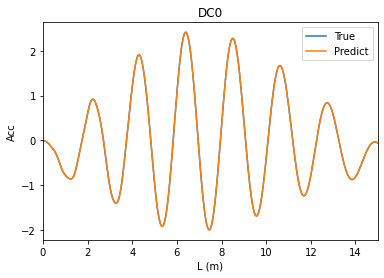

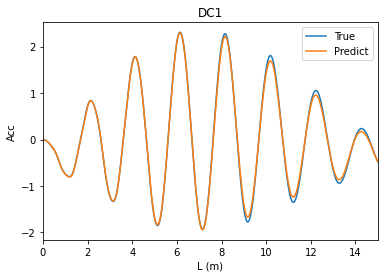

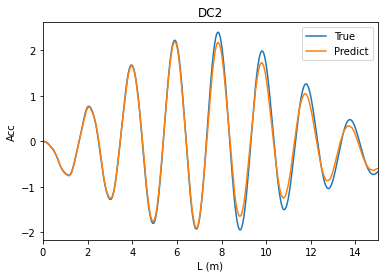

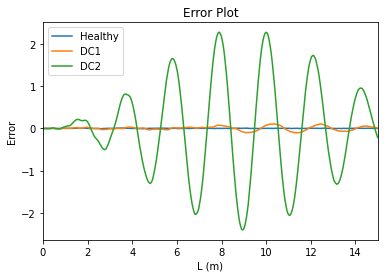

In [17]:
# plotting Training and testing data 
X_Dam_00_Pred=Conv_AE.predict(X_Dam_00_map,batch_size=batch_size)
X_Dam_15_Pred=Conv_AE.predict(X_Dam_15_map,batch_size=batch_size)
X_Dam_30_Pred=Conv_AE.predict(X_Dam_30_map,batch_size=batch_size)



for sample in range(1):
    plt.figure()
    plt.plot(dist,X_Dam_00_map[sample,:], label='True')
    plt.plot(dist,X_Dam_00_Pred[sample][:, 0], label='Predict')
    plt.xlim(0,15)
    plt.xlabel('L (m)')
    plt.ylabel('Acc')
    plt.title('DC0')
    plt.legend()



for sample in range(1):
    plt.figure()
    plt.plot(dist,X_Dam_15_map[sample,:], label='True')
    plt.plot(dist,X_Dam_15_Pred[sample][:, 0], label='Predict')
    plt.xlim(0,15)
    plt.xlabel('L (m)')
    plt.ylabel('Acc')
    plt.title('DC1')
    plt.legend()



for sample in range(1):
    plt.figure()
    plt.plot(dist,X_Dam_30_map[sample,:], label='True')
    plt.plot(dist,X_Dam_30_Pred[sample][:, 0], label='Predict')
    plt.xlim(0,15)
    plt.xlabel('L (m)')
    plt.ylabel('Acc')
    plt.title('DC2')
    plt.legend()

plt.figure()
plt.plot(dist,X_Dam_00_map[2,:]-X_Dam_00_Pred[2,:],label='Healthy')
plt.plot(dist,X_Dam_15_map[2,:]-X_Dam_15_Pred[2,:],label='DC1')
plt.plot(dist,X_Dam_15_map[2,:]-X_Dam_30_Pred[2,:],label='DC2')
plt.xlim(0,15)
plt.xlabel('L (m)')
plt.ylabel('Error')
plt.title('Error Plot')
plt.legend()

**End**